<a href="https://colab.research.google.com/github/ankit1khare/Easy_street_parking_with_MASK-RCNN/blob/master/park_clever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# !pip install jupyterlab

In [0]:
# !npm config set prefix /usr/local

In [0]:
# !npm install localtunnel


In [0]:
# jupyter_running = !jupyter notebook list | grep 8888
# if not jupyter_running:
#   !mkdir -p /content/.jupyter
#   !echo '{ "NotebookApp": { "password": "4d6ed2c10da3aeaba70c40a26ed2e659b75e3dfd" } }' > /content/.jupyter/jupyter_notebook_config.json
#   get_ipython().system_raw('jupyter lab &')
# !ssh -o ServerAliveInterval=60 -o StrictHostKeyChecking=no -R deviprasadtripathy:80:localhost:8888 serveo.net 1>/dev/null

In [0]:
# from IPython.lib import passwd
# password = passwd("secret")
# password

In [0]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 923, done.
remote: Total 923 (delta 0), reused 0 (delta 0), pack-reused 923
Receiving objects: 100% (923/923), 139.77 MiB | 11.17 MiB/s, done.
Resolving deltas: 100% (521/521), done.


In [3]:
!pip3 install twilio

    100% |████████████████████████████████| 952kB 21.9MB/s 


In [0]:
import os
os.chdir("/content/drive/My Drive/AK49/Mask_RCNN/")
# os.chdir("..")

In [5]:
import numpy as np
import cv2
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path
from twilio.rest import Client

Using TensorFlow backend.


In [0]:
import matplotlib as pt

In [0]:
# !rm -r ak
# !mkdir ak

Current frame counter0


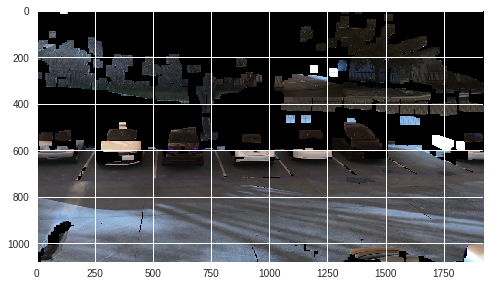

Current frame counter5


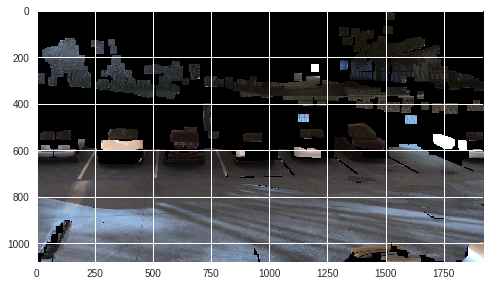

Current frame counter10


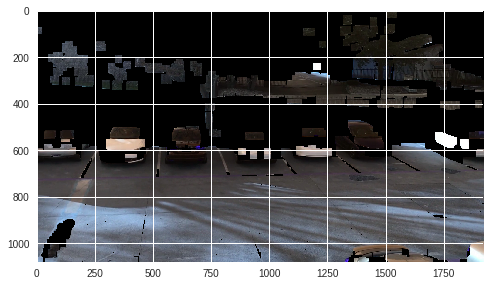

Current frame counter15


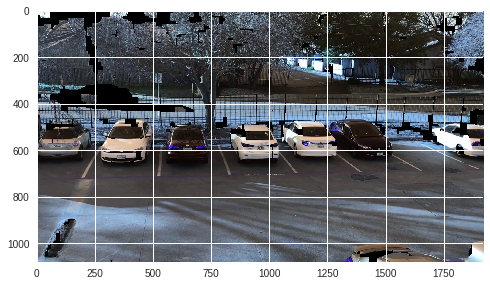

Current frame counter20


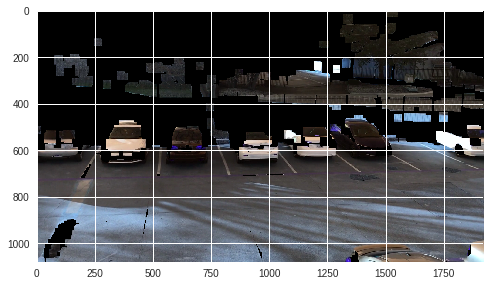

Current frame counter25


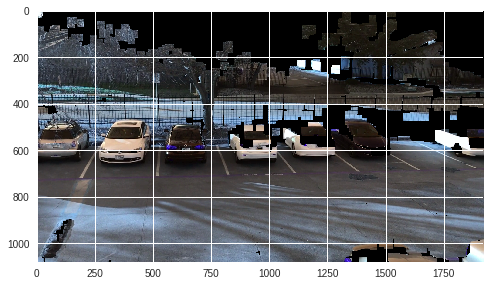

Current frame counter30


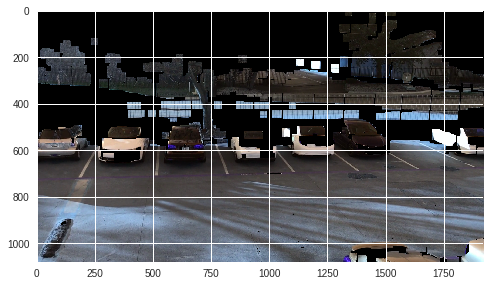

Current frame counter35


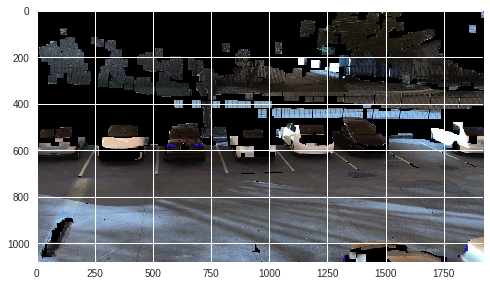

going in to mark vehicles. Frame number:   41
SENDING SMS!!!
Hope you got the message on your phone
couldn't read video
Video finished


In [27]:
# Mask-RCNN config
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  
    DETECTION_MIN_CONFIDENCE = 0.6 #setted to 60%


# Filter to only cars
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

# Twilio config
twilio_account_sid = 'aaaaaaaaaaaaaaaaaaaaa'
twilio_auth_token = 'aaaaaaaaaaaaaa'
twilio_phone_number = '+9999999'
destination_phone_number = '+199999999'
client = Client(twilio_account_sid, twilio_auth_token)

# Root dir
ROOT_DIR = Path(".")

#Trained model loc
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

VIDEO_SOURCE = "test_images/stace_park.mp4"

model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

model.load_weights(COCO_MODEL_PATH, by_name=True)

# spotted parking spaces
parked_car_boxes = None

video_capture = cv2.VideoCapture(VIDEO_SOURCE)

free_space_frames = 0
sms_sent = False
count = 0
temp = np.array(4,)

parked_car_boxes1 = [None] * 11

def checkEqual2(iterator):
   print(iterator)
#     return len(set(iterator)) <= 1
  
# Loop over each frame in the video
counter = 0
ref_image = None
ref_image_color = None
cumm_image = None
img_thresh_sub1 = None
final_ref = None
while video_capture.isOpened():
    success, frame = video_capture.read()
    
    #image = frame
    if not success:
        print("couldn't read video")
        break
        
    elif counter<40:
      #create another video reader object to compare the two frames and verify the possibility of motion
      success, frame2 = video_capture.read()
      d = cv2.absdiff(frame, frame2)  
      grey = cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(grey, (1, 1), 0)
      ret, th = cv2.threshold( blur, 20, 255, cv2.THRESH_BINARY)
      
      #perform these morphological transformations to erode the car which is moving so that it is not detected by MASKRCNN. Take the eorsion levels to be high. 
      dilated = cv2.dilate(th, np.ones((30, 30), np.uint8), iterations=1 )
      eroded = cv2.erode(dilated, np.ones((30, 30), np.uint8), iterations=1 )
        
      #fill the contours for even a better morphing of the vehicle
      img, c, h = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      frame2 = cv2.drawContours(frame2, c, -1, (0,0,0), cv2.FILLED)
      
      
      #       for cont in c:
#           epsilon = 0.01 * cv2.arcLength(cont, True)
#           approx = cv2.approxPolyDP(cont, epsilon, True)
#           frame2 = cv2.drawContours(frame2, [approx], 0, (255,255,255), cv2.FILLED)
        
#         rect = cv2.minAreaRect(cont)
#         box= cv2.boxPoints(rect)
#         box=np.int0(box)
#         frame2 = cv2.drawContours(frame2, [box], 0, (0,0,0), cv2.FILLED)


#       print(c)
#       cv2.drawContours(frame2, c, -1, Scalar(255), cv2.FILLED)
#       des = cv2.bitwise_not(frame2)
#       contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

#       for cnt in contour:
#         cv2.drawContours(des,[cnt],0,255,-1)

#       gray = cv2.bitwise_not(des)
#       cv2.fillPoly(img, pts =[c], color=(255,255,255))


       
      if counter%5 == 0:
        print("Current frame counter" + str(counter))
        pt.pyplot.imshow(frame2)
        pt.pyplot.show()
        
      counter = counter + 1
      continue
    
    # Converting the image from BGR color used by OpenCV to RGB color. 
    if counter==40:
      rgb_image = frame2[:,:,::-1]
      counter+=1
    else:
      rgb_image = frame[:, :, ::-1]
      
    results = model.detect([rgb_image], verbose=0)

    # Mask R-CNN assumes we are running detection on multiple images.
    # We only passed in one image to detect, so only grab the first result.
    r = results[0]

    # The r variable will now have the results of detection:
    # - r['rois'] are the bounding box of each detected object
    # - r['class_ids'] are the class id (type) of each detected object
    # - r['scores'] are the confidence scores for each detection
    # - r['masks'] are the object masks for each detected object (which gives you the object outline)
    if parked_car_boxes is None:
        print("going in to mark vehicles. Frame number:  ", counter)
        video_capture = cv2.VideoCapture(VIDEO_SOURCE)
        # This is the first frame of video - assume all the cars detected are in parking spaces.
        # Save the location of each car as a parking space box and go to the next frame of video.
        parked_car_boxes = get_car_boxes(r['rois'], r['class_ids'])
          
    else:
        # Get where cars are currently located in the frame
        car_boxes = get_car_boxes(r['rois'], r['class_ids'])

        # See how much those cars overlap with the known parking spaces
        overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

        # Assume no spaces are free until we find one that is free
        free_space = False

        # Loop through each known parking space box
        for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):

            # For this parking space, find the max amount it was covered by any
            # car that was detected in our image (doesn't really matter which car)
            max_IoU_overlap = np.max(overlap_areas)

            # Get the top-left and bottom-right coordinates of the parking area
            y1, x1, y2, x2 = parking_area

            # Check if the parking space is occupied by seeing if any car overlaps
            # it by more than 0.15 using IoU
            if max_IoU_overlap < 0.15:
                # Parking space not occupied! Draw a green box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                # Flag that we have seen at least one open space
                free_space = True
            else:
                # Parking space is still occupied - draw a red box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)

            # Write the IoU measurement inside the box
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"{max_IoU_overlap:0.2}", (x1 + 6, y2 - 6), font, 0.3, (255, 255, 255))

        # If at least one space was free, start counting frames
        # This is so we don't alert based on one frame of a spot being open.
        # This helps prevent the script triggered on one bad detection.
        if free_space:
            free_space_frames += 1
        else:
            # If no spots are free, reset the count
            free_space_frames = 0

        # If a space has been free for several frames, we are pretty sure it is really free!
        if free_space_frames > 120:
            # Write SPACE AVAILABLE!! at the top of the screen
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"SPACE AVAILABLE!", (10, 150), font, 3.0, (0, 255, 0), 2, cv2.FILLED)
            
            # If we haven't sent an SMS yet, sent it!
            if not sms_sent:
                print("SENDING SMS!!!")
                message = client.messages.create(
                    body="Parking space available!!!",
                    from_=twilio_phone_number,
                    to=destination_phone_number
                )
                sms_sent = True
                print("Hope you got the message on your phone")

        # Show the frame of video on the screen
#         cv2.imshow('Video', frame)
    #saving each frame
    name = str(count) + ".jpg"
    name = os.path.join('./ak', name)
    cv2.imwrite(name, frame)
    count+=1
    
    #'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
print("Video finished")
video_capture.release()
# cv2.destroyAllWindows()

In [28]:
#create video including all the frames in the ak folder
import glob

images = list(glob.iglob(os.path.join('./ak', '*.*')))
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

# Get all image file paths to a list.
# Sort the images by name index.
# images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid
  
make_video('./better.mp4', images, fps=30)  


<VideoWriter 0x7f30f6b882f0>

In [0]:
# !cp -a Mask_RCNN/ drive/My\ Drive/AK49/